In [ ]:
!pip install qiskit
!pip install qiskit_aer
!pip install qiskit_machine_learning
import os
import time
from qiskit.quantum_info import Pauli
import torch
import torch.nn as nn
from qiskit import QuantumCircuit
from qiskit.circuit.library import PauliFeatureMap, RealAmplitudes
from qiskit_aer import AerSimulator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sympy.core.random import randint
from torch.sparse import log_softmax
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F
import torch.autograd as autograd
from qiskit_machine_learning.connectors import TorchConnector
from qiskit import *
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit import transpile
from qiskit_aer import Aer
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.1/231.1 kB 5.9 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
class quantum_layer:
    def __init__(self,nbqbitin,nbqbitout):
        self.nbqbitin = nbqbitin
        self.nbqbitout = nbqbitout

        self.circuit = self.create_circuit(4)
    def create_circuit(self,nbqbits=8):
        def conv_circuit(params):
            target = QuantumCircuit(2)
            target.rz(-np.pi / 2, 1)
            target.cx(1, 0)
            target.rz(params[0], 0)
            target.ry(params[1], 1)
            target.cx(0, 1)
            target.ry(params[2], 1)
            target.cx(1, 0)
            target.rz(np.pi / 2, 0)
            return target

        def conv_layer(num_qubits, param_prefix):
            qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
            qubits = list(range(num_qubits))
            param_index = 0
            params = ParameterVector(param_prefix, length=num_qubits * 3)
            for q1, q2 in zip(qubits[0::2], qubits[1::2]):
                qc = qc.compose(conv_circuit(params[param_index: (param_index + 3)]), [q1, q2])
                qc.barrier()
                param_index += 3
            for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
                qc = qc.compose(conv_circuit(params[param_index: (param_index + 3)]), [q1, q2])
                qc.barrier()
                param_index += 3

            qc_inst = qc.to_instruction()

            qc = QuantumCircuit(num_qubits)
            qc.append(qc_inst, qubits)
            return qc

        def pool_circuit(params):
            target = QuantumCircuit(2)
            target.rz(-np.pi / 2, 1)
            target.cx(1, 0)
            target.rz(params[0], 0)
            target.ry(params[1], 1)
            target.cx(0, 1)
            target.ry(params[2], 1)

            return target

        def pool_layer(sources, sinks, param_prefix):
            num_qubits = len(sources) + len(sinks)
            qc = QuantumCircuit(num_qubits, name="Pooling Layer")
            param_index = 0
            params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
            for source, sink in zip(sources, sinks):
                qc = qc.compose(pool_circuit(params[param_index: (param_index + 3)]), [source, sink])
                qc.barrier()
                param_index += 3

            qc_inst = qc.to_instruction()

            qc = QuantumCircuit(num_qubits)
            qc.append(qc_inst, range(num_qubits))
            return qc

        feature_map = ZFeatureMap(nbqbits)

        ansatz = QuantumCircuit(nbqbits, name="Ansatz")

        # First Convolutional Layer
        # ansatz.compose(conv_layer(nbqbits, "c1"), list(range(nbqbits)), inplace=True)
        #
        # # First Pooling Layer
        # ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

        # Second Convolutional Layer
        ansatz.compose(conv_layer(4, "c2"), list(range(0, 4)), inplace=True)

        # Second Pooling Layer
        ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(0, 4)), inplace=True)

        # Third Convolutional Layer

        # Third Pooling Layer


        # Combining the feature map and ansatz
        circuit = QuantumCircuit(4)
        circuit.compose(feature_map, range(4), inplace=True)
        circuit.compose(ansatz, range(4), inplace=True)
        circuit.x(list(range(4)))

        observable = [Pauli('I' * i + 'Z' + 'I' * (4  - i - 1)) for i in range(2, 4)]


        backend_options = {'method': 'statevector', 'max_parallel_threads': 4}
        backend = AerSimulator(**backend_options)
        circuit = transpile(circuit, backend=backend, optimization_level=3)




        # we decompose the circuit for the QNN to avoid additional data copying
        qnn = EstimatorQNN(
            circuit=circuit,
            observables=observable,
            input_params=feature_map.parameters,
            weight_params=ansatz.parameters,
        )
        return qnn


def create_quantum_layer(nbqbitin,nbqbitout):
    return quantum_layer(nbqbitin,nbqbitout)

In [ ]:
def quantum_noise(batch_size):
    num_qubits = 1  # Utilisation d'un seul qubit pour le bruit
    shots = 100  # Nombre de mesures (shots)

    # Initialisation du générateur de nombres aléatoires quantiques
    backend = Aer.get_backend('qasm_simulator')

    # Construction du circuit quantique avec une porte Hadamard
    qc = QuantumCircuit(num_qubits, num_qubits)
    qc.h(0)  # Application d'une porte Hadamard sur le qubit
    qc.measure(0, 0)  # Mesure du qubit dans la base standard

    # Exécution du circuit sur le simulateur
    transpiled_circuit = transpile(qc, backend)
    result = backend.run(transpiled_circuit, shots=shots * batch_size, memory=True).result()
    # Extraction des résultats de mesure (0 ou 1)
    memory = result.get_memory()

    # Conversion des résultats en un tenseur PyTorch
    # Remplacement des valeurs '0' et '1' par 0.0 et 1.0
    noise = torch.tensor(
        [1 if bit == '1' else 0 for bit in memory],
        dtype=torch.float32
    )

    # Redimensionnement en [batch_size, shots]
    noise = noise.view(batch_size, shots,1,1)

    return noise

<ipython-input-5-ed897ec9b3d4>:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load('/content/drive/MyDrive/generator_mnist_quantique_layer_nois

tensor([[[[1.]],

         [[0.]],

         [[0.]],

         [[1.]],

         [[0.]],

         [[1.]],

         [[1.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[1.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[1.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[1.]],

         [[0.]],

         [[1.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[1.]],

         [[1.]],

         [[1.]],

         [[1.]],

         [[0.]],

         [[0.]],

         [[1.]],

         [[0.]],

         [[0.]],

         [[1.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[1.]],

         [[1.]],

         [[1.]],

         [[0.]],

         [[1.]],

         [[1.]],

         [[0.]],

         [[0.]],

         [[1.]],

         [[1.]],

         [[0.]],

         [[1.]],

         [[0.]],

         [[1.]],

         [

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 512kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.32MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.63MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



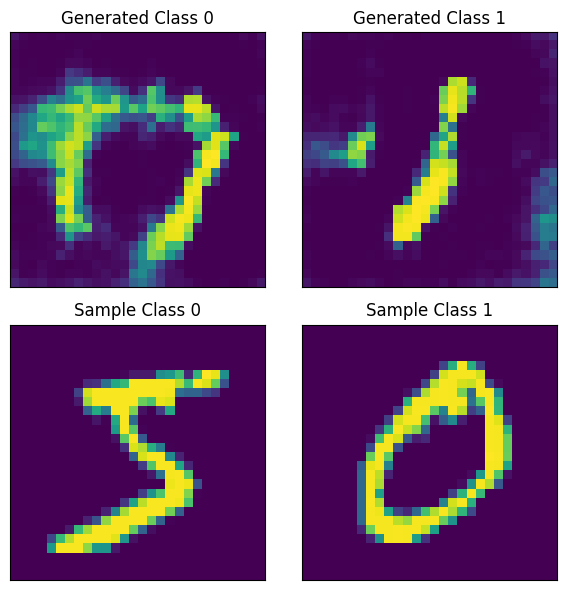

In [ ]:
class Generator(nn.Module):
    def __init__(self, num_classes):
        super(Generator, self).__init__()
        self.num_classes = num_classes
        self.label_embedding = nn.Embedding(num_classes, 100)  # Embedding pour les classes
        self.conv1 = torch.nn.utils.spectral_norm(nn.ConvTranspose2d(100 + 100, 112, 4, 1, 0))
        self.batchnorm1 = nn.BatchNorm2d(112)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.ConvTranspose2d(112, 56, 4, 2, 1)
        self.batchnorm2 = nn.BatchNorm2d(56)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.ConvTranspose2d(56, 28, 4, 2, 1)
        self.conv4 = nn.ConvTranspose2d(28, 1, 4, 2, 3)
        self.lineaire = nn.Linear(28 * 28, 784)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, noise, labels):
        label_embedded = self.label_embedding(labels)  # Embedding de la classe
        x = torch.cat((noise, label_embedded.unsqueeze(2).unsqueeze(3)), dim=1)  # Combine le bruit et l'embedding
        x = self.conv1(x)
        # print(x.size(),"conv1")
        x = self.batchnorm1(x)
        # print(x.size(),"batchnorm1")
        x = self.relu1(x)
        # print(x.size(),"relu1")
        x = self.conv2(x)
        # print(x.size(),"conv2")
        x = self.batchnorm2(x)
        # print(x.size(),"batchnorm2")
        x = self.relu2(x)
        # print(x.size(),"relu2")
        x = self.conv3(x)
        # print(x.size(),"conv3")
        x = self.conv4(x)
        # print(x.size(),"conv4")
        x = self.sigmoid(x)

        self.savereseau()
        return x

    def savereseau(self):
        torch.save(self.state_dict(), 'generator_mnist.pth')

    def loadreseau(self):
        self.load_state_dict(torch.load('/content/drive/MyDrive/generator_mnist_quantique_layer_noise.pth'))
        self.eval()

    def nb_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Bloc pour classer l'image
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(1600, 512)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 4)
        self.quantum_layer=TorchConnector(create_quantum_layer(4,2).circuit)
        self.fc_real_fake = nn.Linear(512, 1)  # Pour évaluer si l'image est réelle ou fausse

    def forward(self, x):
        # Bloc de convolution et de pooling
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Flatten et couches entièrement connectées
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)

        # Sorties
        y = F.relu(self.fc2(x))
        y=self.quantum_layer.forward(y)
        class_output = F.log_softmax(y,
                                     dim=1)  # Sortie pour la classification
        real_fake_output = torch.sigmoid(self.fc_real_fake(x))  # Sortie pour vérifier si l'image est réelle
        # print(real_fake_output)
        return class_output, real_fake_output

    def savereseau(self):
        torch.save(self.state_dict(), 'discriminator_mnist.pth')

    def loadreseau(self):
        self.load_state_dict(torch.load('/content/drive/MyDrive/discriminator_mnist_quantique_layer_noise.pth'))
        self.eval()

    def nb_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def gradient_penalty(self, real_images, fake_images, batch_size):
        # Interpolation between real and fake images
        epsilon = torch.rand(batch_size, 1, 1, 1, device=real_images.device)
        interpolated_images = epsilon * real_images + (1 - epsilon) * fake_images
        interpolated_images.requires_grad_(True)

        # Get discriminator output for interpolated images
        _, interpolated_preds = self(interpolated_images)

        # Calculate gradients of the discriminator output with respect to the interpolated images
        gradients = autograd.grad(
            outputs=interpolated_preds,
            inputs=interpolated_images,
            grad_outputs=torch.ones_like(interpolated_preds),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]

        # Reshape gradients to calculate the norm
        gradients = gradients.view(batch_size, -1)
        gradients_norm = gradients.norm(2, dim=1)

        # Calculate the gradient penalty
        penalty = ((gradients_norm - 1) ** 2).mean()
        return penalty


def load_cifar10_data(n_samples=None, classes=None):
    if classes is None:
        classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    X_train = datasets.MNIST(
        root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
    )

    idx = np.isin(X_train.targets, classes)
    X_train.data = X_train.data[idx][:n_samples]
    X_train.targets = np.array(X_train.targets)[idx][:n_samples]

    return X_train


def create_dataloader(dataset, batch_size=1):
    def collate_fn(batch):
        images, targets = zip(*batch)
        images = torch.stack(images)
        targets = torch.tensor(targets, dtype=torch.long)  # Ensure targets are of type Long
        return images, targets

    return DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)


def train(data_loader, resume,num_classes, epochs=10):
    generator = Generator(num_classes=num_classes)
    discriminator = Discriminator()
    print(generator.nb_parameters())
    print(discriminator.nb_parameters())
    if resume:
        generator.loadreseau()
        discriminator.loadreseau()
    generator.train()
    discriminator.train()

    optimizer_gen = torch.optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
    optimizer_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5, 0.999))
    loss_fn_class = nn.CrossEntropyLoss()  # Pour les classes
    loss_fn_real_fake = nn.BCELoss()  # Pour la vérification réelle/faux

    # Liste pour stocker chaque type de perte
    gen_loss_class_list = []
    gen_loss_real_fake_list = []
    disc_loss_class_real_list = []
    # disc_loss_class_fake_list = []
    disc_loss_real_fake_real_list = []
    disc_loss_real_fake_fake_list = []
    real_loss_class = 0
    disc_loss_real_fake_real = 0
    disc_loss_real_fake_fake = 0

    for epoch in range(epochs):
        start_time = time.time()
        for nb, (real_images, real_labels) in enumerate(data_loader):

            batch_size = real_images.size(0)  # Assurez-vous d'utiliser la taille du batch ici
            noise = quantum_noise(batch_size)
            torch_labels = real_labels.clone().detach().long()
            # Générer des images fake avec le générateur
            fake_images = generator(noise, torch_labels)
            optimizer_disc.zero_grad()
            if nb % 1 == 0:
                # Entraînement du Discriminateur

                real_class_preds, real_fake_preds = discriminator(real_images)
                fake_class_preds, fake_fake_preds = discriminator(fake_images.detach())
                real_loss_class = loss_fn_class(real_class_preds,
                                                real_labels)  # À quel point l'image réelle est bien classifiée.
                # fake_loss_class = loss_fn_class(fake_class_preds, real_labels)# a quelle point l'image fake est bien deviné
                disc_loss_real_fake_real = loss_fn_real_fake(real_fake_preds, torch.full((batch_size, 1),
                                                                                         0.9))  # a quelle point l'image reel a bien été deviné reel
                disc_loss_real_fake_fake = loss_fn_real_fake(fake_fake_preds, torch.full((batch_size, 1),
                                                                                         0.1))  # a quelle point l'image fake a bien été deviné fake
                gradient_penalty = discriminator.gradient_penalty(real_images, fake_images, batch_size)

                disc_loss = real_loss_class + disc_loss_real_fake_real + disc_loss_real_fake_fake + gradient_penalty
                disc_loss.backward(retain_graph=True)
                optimizer_disc.step()

            # Entraînement du Générateur
            optimizer_gen.zero_grad()
            fake_class_preds, fake_fake_preds = discriminator(fake_images)
            gen_loss_class = loss_fn_class(fake_class_preds, real_labels)
            gen_loss_real_fake = loss_fn_real_fake(fake_fake_preds, torch.full((batch_size, 1), 0.9))
            gen_loss = gen_loss_class + gen_loss_real_fake
            gen_loss.backward()
            optimizer_gen.step()

            # Enregistrement des pertes individuelles
            gen_loss_class_list.append(gen_loss_class.item())  #
            gen_loss_real_fake_list.append(gen_loss_real_fake.item())
            disc_loss_class_real_list.append(real_loss_class.item())
            # disc_loss_class_fake_list.append(fake_loss_class.item())
            disc_loss_real_fake_real_list.append(disc_loss_real_fake_real.item())
            disc_loss_real_fake_fake_list.append(disc_loss_real_fake_fake.item())
        end_time = time.time()
        generator.savereseau()
        discriminator.savereseau()
        print(
            f"Epoch [{epoch + 1}/{epochs}], Discriminator Loss: {disc_loss.item()}, Generator Loss: {gen_loss.item()},image par seconde: {len(data_loader.dataset) / (end_time - start_time)}")

    # Affichage des courbes des différentes pertes
    plt.figure(figsize=(12, 8))

    # Affichage des pertes sous forme de points
    plt.scatter(range(len(gen_loss_class_list)), gen_loss_class_list, label="Generator Classification Loss", s=10)
    plt.scatter(range(len(gen_loss_real_fake_list)), gen_loss_real_fake_list, label="Generator Real/Fake Loss", s=10)
    plt.scatter(range(len(disc_loss_class_real_list)), disc_loss_class_real_list,
                label="Discriminator Real Classification Loss", s=10)
    plt.scatter(range(len(disc_loss_real_fake_real_list)), disc_loss_real_fake_real_list,
                label="Discriminator Real Real/Fake Loss", s=10)
    plt.scatter(range(len(disc_loss_real_fake_fake_list)), disc_loss_real_fake_fake_list,
                label="Discriminator Fake Real/Fake Loss", s=10)

    # Étiquettes et légende
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Sauvegarde des modèles



def test(generator, num_classes):
    generator.eval()
    images_per_class = 1  # Nombre d'images à générer par classe

    # Créer un tableau pour stocker les images générées
    generated_images = []

    # Générer une image pour chaque classe
    for class_label in range(num_classes):
        noise = quantum_noise(images_per_class)
        print(noise)
        class_tensor = torch.tensor([class_label])
        fake_image = generator(noise, class_tensor)  # Générer l'image
        generated_images.append(fake_image)

    # Convertir la liste en un tenseur

    generated_images = torch.cat(generated_images)

    # Load a sample image from the dataset
    dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())
    sample_images = [dataset[i][0] for i in range(num_classes)]

    # Visualize the images
    fig, axes = plt.subplots(2, num_classes, figsize=(num_classes * 3, 6))
    for i in range(num_classes):
        # Display generated images
        img = generated_images[i]
        axes[0, i].imshow(img.detach().cpu().numpy().squeeze())
        axes[0, i].set_title(f'Generated Class {i}')
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])

        # Display sample images from the dataset
        sample_img = sample_images[i]
        axes[1, i].imshow(sample_img.numpy().squeeze())
        axes[1, i].set_title(f'Sample Class {i}')
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])

    plt.tight_layout()
    plt.show()


def main(mode="train"):
    batch_size = 5  # nb imaga par batch
    nb_image_by_batch = 500 # nb image étudier
    classes = [0, 1]
    epochs = 10
    if mode == "train":
        data = load_cifar10_data(n_samples=nb_image_by_batch,classes=classes)
        data = create_dataloader(data, batch_size=batch_size)

        train(data, epochs=epochs,num_classes=len(classes),resume=False)
    elif mode == "re":
        data = load_cifar10_data(n_samples=nb_image_by_batch,classes=classes)
        data = create_dataloader(data, batch_size=batch_size)
        train(data, epochs=epochs, resume=True,num_classes=len(classes))  # Reprendre l'entraînement
    elif mode == "save":
      # 1. Recréer le générateur et le discriminateur avec le bon nombre de classes
      generator = Generator(num_classes=len(classes))
      discriminator = Discriminator()

      # 2. Charger les modèles depuis la mémoire de la VM
      generator.loadreseau() # Assurez-vous que loadreseau() charge depuis le bon chemin
      discriminator.loadreseau()

      # 3. Sauvegarder sur Google Drive
      save_to_drive(generator, discriminator)
    else:
        generator = Generator(num_classes=len(classes))
        generator.loadreseau()
        test(generator, num_classes=len(classes))


if __name__ == "__main__":
    mode = "test"
    torch.manual_seed(time.time())

    main(mode)


In [ ]:
def save_to_drive(generator, discriminator):
    """Sauvegarde les modèles sur Google Drive."""
    drive.mount('/content/drive')
    save_path_gen = '/content/drive/MyDrive/generator_mnist_quantique_layer_noise.pth'
    save_path_disc = '/content/drive/MyDrive/discriminator_mnist_quantique_layer_noise.pth'

    torch.save(generator.state_dict(), save_path_gen)
    torch.save(discriminator.state_dict(), save_path_disc)

    print(f"Generator saved to: {save_path_gen}")
    print(f"Discriminator saved to: {save_path_disc}")


In [ ]:


torch.save(generator.state_dict(), '/content/drive/MyDrive/generator_mnist_quantique_layer_noise.pth')
torch.save(discriminator.state_dict(), '/content/drive/MyDrive/discriminator_mnist_quantique_layer_noise.pth')

print(f"Model saved to Google Drive at: {save_path}")

NameError: name 'generator' is not defined